# 🚀 Optimization Techniques for Deep Learning

**Contents**
1. Introduction: What is Optimization?
2. The Core Idea: Gradient Descent
3. Gradient Descent Variants (Batch, Mini-Batch, SGD)
4. Challenges with Basic Optimizers (Saddle Points, Ravines)
5. Momentum and Nesterov Accelerated Gradient (NAG)
6. Adaptive Learning Rate Methods (Adagrad, RMSprop, Adam)
7. Visualizing Optimizer Paths (NumPy)
8. Practical Comparison: Training an MLP with PyTorch
9. Summary

## Prerequisites

We will use:
- `numpy` for calculations and visualizations.
- `matplotlib` for plotting.
- `torch` for a practical deep learning comparison. This notebook assumes `torch` is installed.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
np.random.seed(42)
torch.manual_seed(42)
%matplotlib inline

## 1) Introduction: What is Optimization?

In deep learning, **optimization** is the process of finding the set of model parameters (weights $\mathbf{W}$ and biases $\mathbf{b}$) that minimizes a **loss function** $\mathcal{L}$.

The loss function measures the difference between the model's predictions ($\hat{\mathbf{y}}$) and the true labels ($\mathbf{y}$). By minimizing this loss, we are "training" the model to make better predictions.

All training algorithms we'll discuss are built on one core idea: **Gradient Descent**.

## 2) The Core Idea: Gradient Descent

The **gradient** ($\nabla$) of the loss function with respect to a parameter (e.g., a weight $w$) tells us two things:
1.  **Direction:** The direction of the *steepest ascent* (where the loss *increases* the most).
2.  **Magnitude:** How steep the ascent is.

To minimize the loss, we want to move in the *opposite* direction of the gradient. This is the core idea of **Gradient Descent**.

The update rule for a single parameter $\theta$ (which can be any weight or bias) is:
$$
\theta_{\text{new}} = \theta_{\text{old}} - \eta \cdot \nabla_{\theta} \mathcal{L}
$$

- $\theta$ is the parameter we are updating.
- $\nabla_{\theta} \mathcal{L}$ is the gradient of the loss $\mathcal{L}$ with respect to $\theta$. (This is what **Backpropagation** calculates!)
- $\eta$ (eta) is the **learning rate**, a hyperparameter that controls how big of a step we take.

> **Analogy:** Imagine you are on a mountain in a thick fog (the loss landscape) and you want to get to the lowest valley (minimum loss). You can only feel the slope under your feet (the gradient). To get down, you take a step in the direction of the steepest *downward* slope (the negative gradient). The size of your step is the learning rate.

## 3) Gradient Descent Variants

The main difference between Gradient Descent variants is *how much data* we use to compute the gradient for each parameter update.

### 🔹 Batch Gradient Descent (BGD)
Computes the gradient using the **entire training dataset**.
$$
\theta = \theta - \eta \cdot \nabla_{\theta} \mathcal{L}(X, \mathbf{y})
$$
- **Pros:** Stable, convergent. The gradient estimate is exact.
- **Cons:** Incredibly slow and memory-intensive. For a dataset with 1 million samples, you must process all 1 million samples just to make *one* parameter update. Infeasible for modern deep learning.

### 🔹 Stochastic Gradient Descent (SGD)
Computes the gradient using just **one training sample** at a time.
$$
\theta = \theta - \eta \cdot \nabla_{\theta} \mathcal{L}(\mathbf{x}^{(i)}, y^{(i)})
$$
- **Pros:** Very fast updates. Low memory cost.
- **Cons:** Very noisy. The loss will bounce around a lot. This high variance can make convergence difficult, though it can also help escape shallow local minima.

### 🔹 Mini-Batch Gradient Descent (MBGD)
This is the **practical standard** used in all modern deep learning. It's a compromise between BGD and SGD.

Computes the gradient using a **small batch** of data (e.g., 32, 64, or 128 samples).
$$
\theta = \theta - \eta \cdot \nabla_{\theta} \mathcal{L}(X_{\text{batch}}, \mathbf{y}_{\text{batch}})
$$
- **Pros:**
  - **Efficiency:** Much faster convergence than BGD.
  - **Stability:** Less noisy than SGD, leading to more stable convergence.
  - **Hardware:** Allows for parallel processing on GPUs, as matrix operations are most efficient on batches of data.

> **Note:** In practice, when people say "SGD," they almost always mean **Mini-Batch Gradient Descent**. We will use "SGD" in this context from now on.

## 4) Challenges with Basic Optimizers

Basic Mini-Batch GD (often just called `SGD`) still has problems:

1.  **Choosing the Learning Rate ($\eta$):** This is very difficult.
    - Too large: The optimizer overshoots the minimum and diverges.
    - Too small: Training is extremely slow.

2.  **Saddle Points:** In high-dimensional landscapes (like in neural networks), we are more likely to encounter saddle points than local minima. A saddle point is a place where the gradient is zero in all directions, but it's not a minimum. Basic SGD can get "stuck" on these plateaus.

3.  **Ravines (Pathological Curvature):** The loss landscape can be very different in different directions. Imagine a long, narrow valley (a ravine). The gradient is very steep on the walls but very shallow along the bottom. SGD will oscillate back and forth on the steep walls while making very slow progress along the valley towards the minimum.



These challenges led to the development of more advanced optimizers.

## 5) Momentum and Nesterov Accelerated Gradient (NAG)

These methods aim to solve the ravine and saddle point problems by adding a "velocity" or "momentum" term.

### 🔸 Momentum

Momentum adds a fraction $\beta$ (the momentum coefficient, e.g., 0.9) of the *previous* update vector to the current gradient.

**Intuition:** It's like a heavy ball rolling down the loss landscape.
- In the ravine, the back-and-forth oscillations on the walls tend to cancel out, while the gradients along the valley bottom consistently add up.
- This builds up **velocity** ($v_t$) in the correct direction, allowing the optimizer to move faster along the shallow slope and "roll" through small local minima and saddle points.

**Formulas:**
$$
v_t = \beta v_{t-1} + (1-\beta) \cdot \nabla_{\theta} \mathcal{L} \quad \text{(A common variant uses } v_t = \beta v_{t-1} + \eta \cdot \nabla_{\theta} \mathcal{L} \text{)}
$$
$$
\theta = \theta - \eta v_t
$$

- $v_t$ is the velocity vector at time $t$.
- $\beta$ is the momentum term (e.g., 0.9). A higher $\beta$ means past gradients have more influence.

### 🔸 Nesterov Accelerated Gradient (NAG)

NAG is a slightly smarter version of Momentum.

**Intuition:** Instead of calculating the gradient at the *current* position (like standard Momentum), NAG first "looks ahead" by taking a step in the direction of its current velocity. It then calculates the gradient *at that future position* and uses it to make a correction.

This "look-ahead" property helps it slow down *before* it overshoots a minimum, making it more stable than standard Momentum.

**Formulas (simplified):**
$$
v_t = \beta v_{t-1} + \eta \cdot \nabla_{\theta} \mathcal{L}(\theta - \beta v_{t-1})
$$
$$
\theta = \theta - v_t
$$

Notice the gradient $\nabla_{\theta} \mathcal{L}$ is computed at $\theta - \beta v_{t-1}$ (the "look-ahead" point).

## 6) Adaptive Learning Rate Methods

This family of optimizers solves another major problem: they **automatically adapt the learning rate** for *each parameter individually*.

The intuition is that parameters that receive large gradients (or are updated frequently) should have their learning rate reduced, while parameters with small gradients (or updated infrequently) should get a boost.

### 🔹 Adagrad (Adaptive Gradient Algorithm)

Adagrad accumulates the *sum of squared gradients* for each parameter and divides the learning rate by the square root of this sum.

**Formulas (for a single parameter $\theta_i$):**
Let $g_t = \nabla_{\theta_i} \mathcal{L}$.
1.  Accumulate squared gradients: $G_t = G_{t-1} + g_t^2$
2.  Update parameter: $\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_t + \epsilon}} \cdot g_t$

- $G_t$ is the sum of squared gradients up to time $t$.
- $\epsilon$ (epsilon) is a tiny value (e.g., $1e-8$) to prevent division by zero.

- **Pros:** Great for sparse data (e.g., NLP), as it boosts learning for infrequent features.
- **Cons:** The accumulated sum $G_t$ only grows. This causes the learning rate to monotonically decrease, eventually becoming so small that training stops entirely.

### 🔹 RMSprop (Root Mean Square Propagation)

RMSprop (developed by Geoffrey Hinton) fixes Adagrad's dying learning rate problem by using an **exponentially decaying moving average** of squared gradients instead of a sum.

**Formulas:**
Let $g_t = \nabla_{\theta_i} \mathcal{L}$.
1.  Compute moving average of squared gradients:
    $$E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma) g_t^2$$
2.  Update parameter:
    $$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} \cdot g_t$$

- $\gamma$ is a decay rate (e.g., 0.9 or 0.99) that controls the "memory" of the average.

By using a moving average, $E[g^2]_t$ doesn't grow forever, and the learning rate adapts based on *recent* gradient information.

### 🔸 Adam (Adaptive Moment Estimation)

**Adam is the most common, default optimizer used in deep learning today.**

It combines the two best ideas:
1.  **Momentum:** It keeps an exponentially decaying moving average of the *gradients* (the 1st moment, $m_t$), just like Momentum.
2.  **Adaptive LR:** It keeps an exponentially decaying moving average of the *squared gradients* (the 2nd moment, $v_t$), just like RMSprop.

**Formulas:**
Let $g_t = \nabla_{\theta} \mathcal{L}$.
1.  Update 1st moment (momentum):
    $$m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t$$
2.  Update 2nd moment (RMSprop):
    $$v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2$$

Adam also includes a **bias-correction** step to account for the fact that $m_t$ and $v_t$ are initialized at zero (which would bias them towards zero in the initial steps):
3.  Bias correction:
    $$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
    $$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$

4.  Final parameter update:
    $$\theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \cdot \hat{m}_t$$

- $\beta_1$ is the momentum decay (e.g., 0.9).
- $\beta_2$ is the squared gradient decay (e.g., 0.999).
- $\eta$ is the learning rate (e.g., 0.001).

Adam is powerful because it gives you the speed of Momentum and the per-parameter adaptivity of RMSprop. It just *works* very well on a wide range of problems with its default settings.

## 7) Visualizing Optimizer Paths (NumPy)

Let's visualize how these optimizers navigate a difficult loss landscape. We'll use the **Himmelblau function**, which has multiple local minima and provides a good test for optimizer behavior.

We will implement simplified versions of the optimizers *for visualization only*. (Don't use these for real training!)

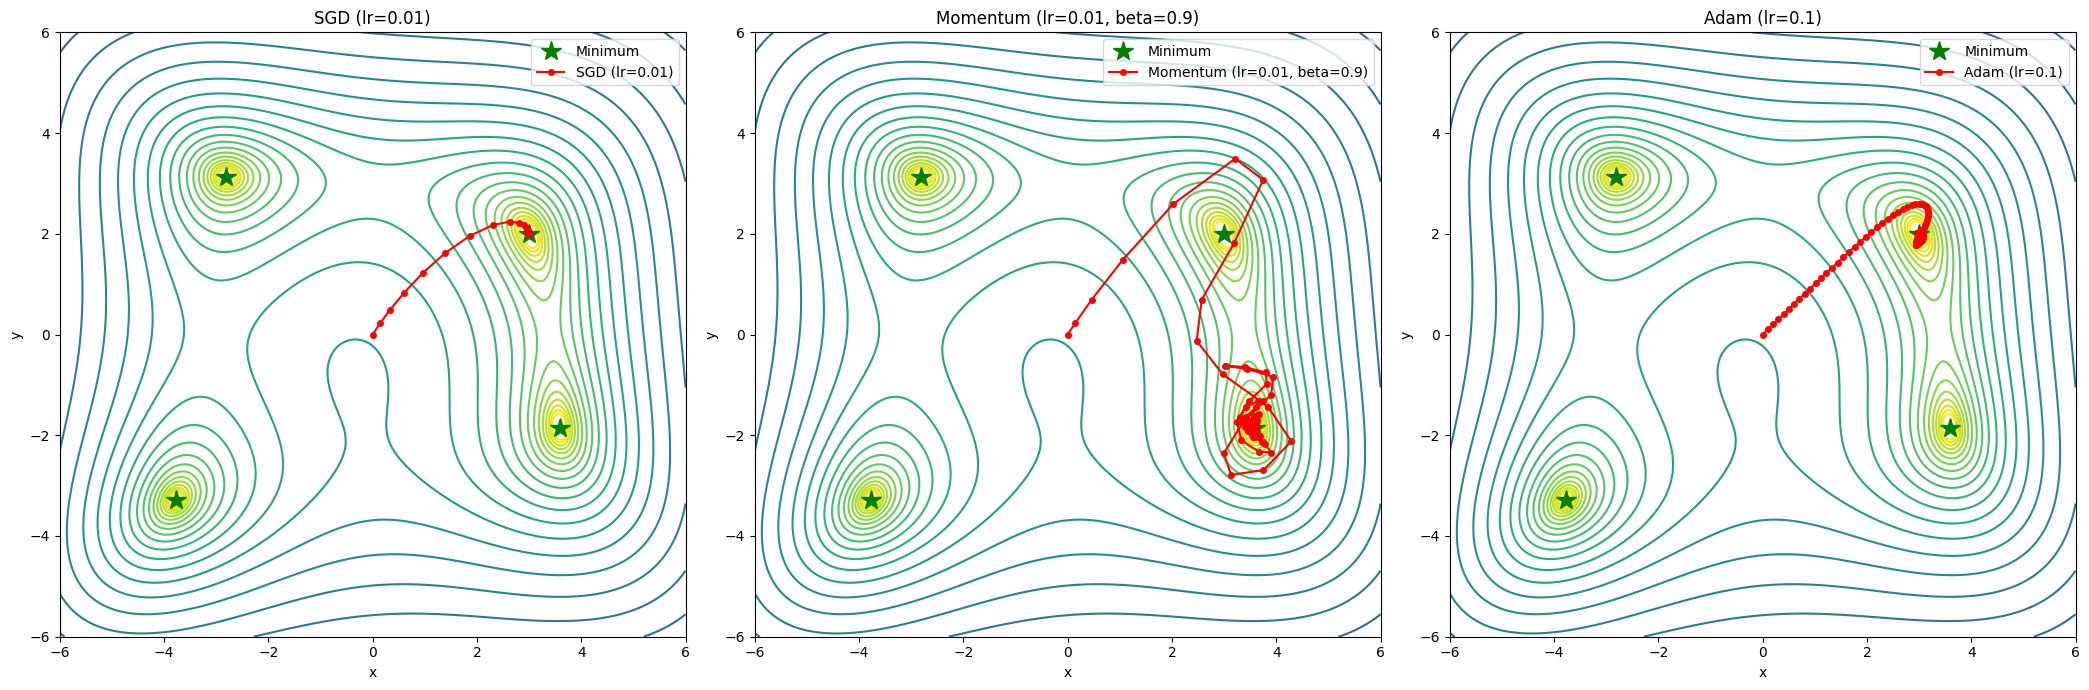

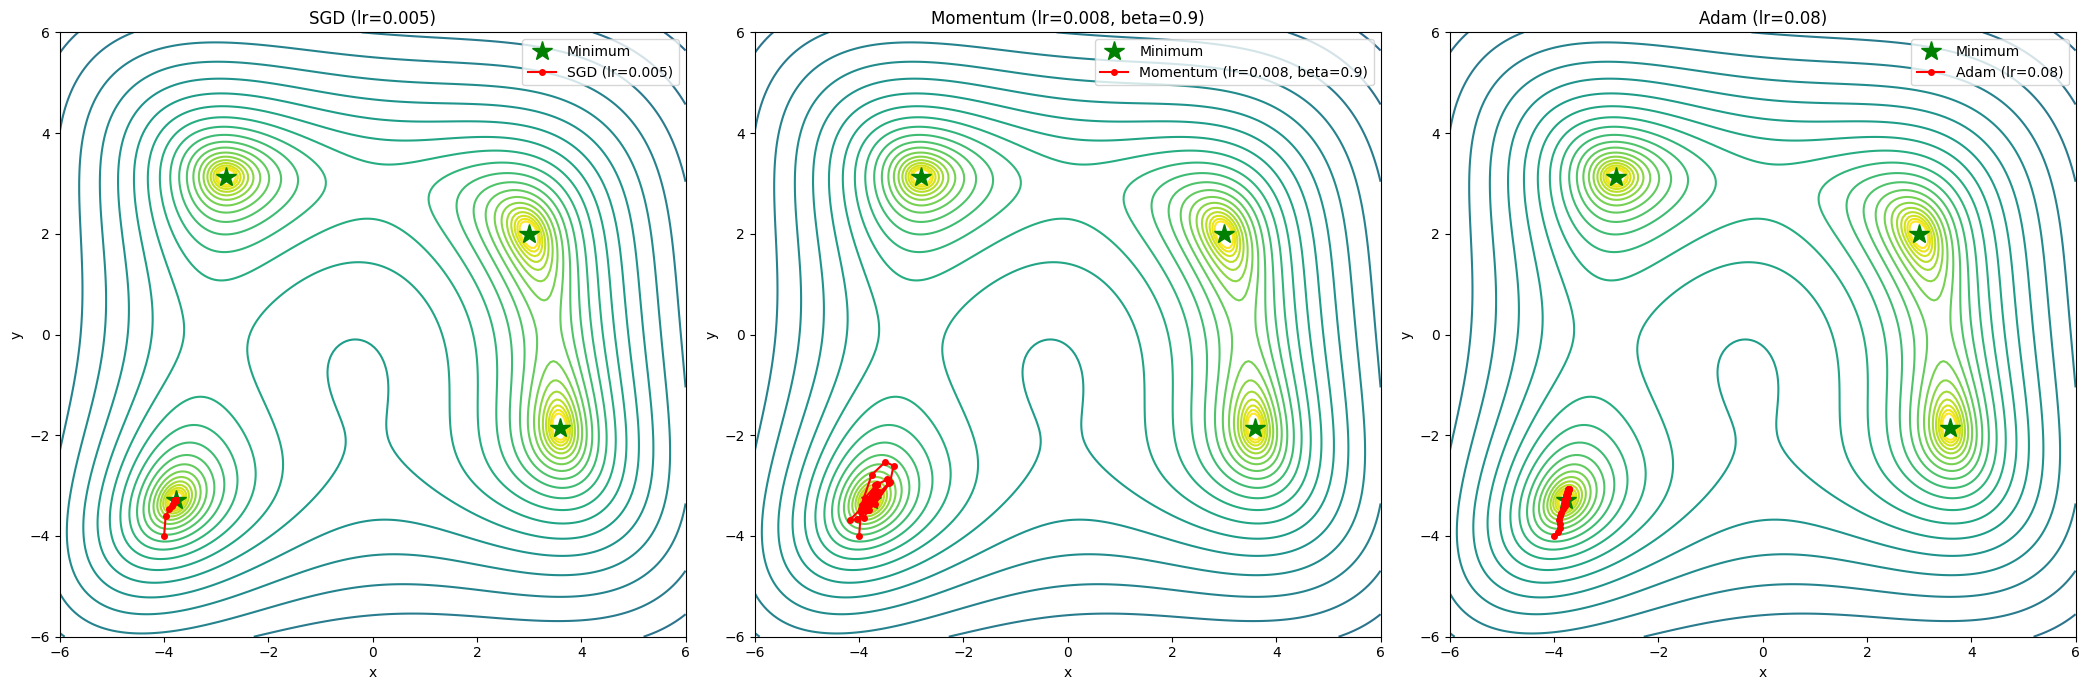

In [4]:
# Define the Himmelblau function using PyTorch
def himmelblau_function_torch(params):
    x, y = params[0], params[1]
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


# Set up the plotting grid for Himmelblau function
X_grid, Y_grid = np.meshgrid(np.linspace(-6, 6, 200), np.linspace(-6, 6, 200))
Z_grid = himmelblau_function_torch(torch.tensor([X_grid, Y_grid], dtype=torch.float32)).detach().numpy()

def plot_optimizer_path(paths, titles):
    n = len(paths)
    fig, axes = plt.subplots(1, n, figsize=(n * 7, 7))
    if n == 1: axes = [axes]
    for ax, path, title in zip(axes, paths, titles):
        ax.contour(X_grid, Y_grid, Z_grid, levels=np.logspace(0, 5, 30), norm=plt.cm.colors.LogNorm(), cmap='viridis_r')
        # Mark the four minima of the Himmelblau function
        minima = [(3, 2), (-2.805118, 3.131312), (-3.779310, -3.283186), (3.584428, -1.848126)]
        for mx, my in minima:
             ax.plot(mx, my, 'g*', markersize=15, label='Minimum' if (mx, my) == minima[0] else "") # Add label only once
        ax.plot(path[:, 0], path[:, 1], 'r-o', markersize=4, linewidth=1.5, label=title)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(title)
        ax.legend()
        ax.set_xlim([-6, 6]) # Set consistent limits
        ax.set_ylim([-6, 6]) # Set consistent limits
    plt.tight_layout() # Adjust layout
    plt.show()

# Optimizer simulation using torch.optim
def run_optimizer_torch(optimizer_class, start_pos, lr, **kwargs):
    path = [start_pos]
    pos = torch.tensor(start_pos, dtype=torch.float32, requires_grad=True)
    optimizer = optimizer_class([pos], lr=lr, **kwargs)

    for _ in range(100):
        optimizer.zero_grad()
        loss = himmelblau_function_torch(pos)
        loss.backward()
        optimizer.step()
        path.append(pos.detach().numpy().copy()) # Append a copy of the detached numpy array
    return np.array(path)

# --- Run and Plot --- #
start = np.array([0, 0]) # Starting point near the center

# Use torch.optim optimizers
path_sgd = run_optimizer_torch(torch.optim.SGD, start, lr=0.01)
path_momentum = run_optimizer_torch(torch.optim.SGD, start, lr=0.01, momentum=0.9)
path_adam = run_optimizer_torch(torch.optim.Adam, start, lr=0.1) # Adam typically needs a larger LR

plot_optimizer_path([path_sgd, path_momentum, path_adam], ['SGD (lr=0.01)', 'Momentum (lr=0.01, beta=0.9)', 'Adam (lr=0.1)'])

# Example with different LRs and start point
start_alt = np.array([-4, -4]) # Starting point further away

path_sgd_alt = run_optimizer_torch(torch.optim.SGD, start_alt, lr=0.005) # Smaller LR for SGD
path_momentum_alt = run_optimizer_torch(torch.optim.SGD, start_alt, lr=0.008, momentum=0.9) # Slightly larger LR for Momentum
path_adam_alt = run_optimizer_torch(torch.optim.Adam, start_alt, lr=0.08) # Adjusted Adam LR

plot_optimizer_path([path_sgd_alt, path_momentum_alt, path_adam_alt], ['SGD (lr=0.005)', 'Momentum (lr=0.008, beta=0.9)', 'Adam (lr=0.08)'])

**Visualization Takeaways:**

1.  **SGD:** With a "safe" (small) learning rate, SGD moves very, very slowly toward the minimum. It makes progress, but it's plodding.
2.  **Momentum:** With the same small LR, Momentum builds up speed and covers much more ground, getting closer to the minimum.
3.  **Adam:** Adam (with a more appropriate LR) heads confidently toward the minimum, adapting its step size and converging much faster than the others.

This shows the **robustness** of Adam. It's much less sensitive to the choice of learning rate than the other methods.

## 8) Practical Comparison: Training an MLP with PyTorch

Now let's train a simple network with different optimizers from `torch.optim`, using a synthetic dataset generated with `make_classification`.

We will plot their training loss curves to see who learns fastest.

SGD (lr=0.01): Final val acc 0.7333
SGD+Momentum (lr=0.01): Final val acc 0.7700
RMSprop (lr=0.001): Final val acc 0.7600
Adam (lr=0.001): Final val acc 0.7633


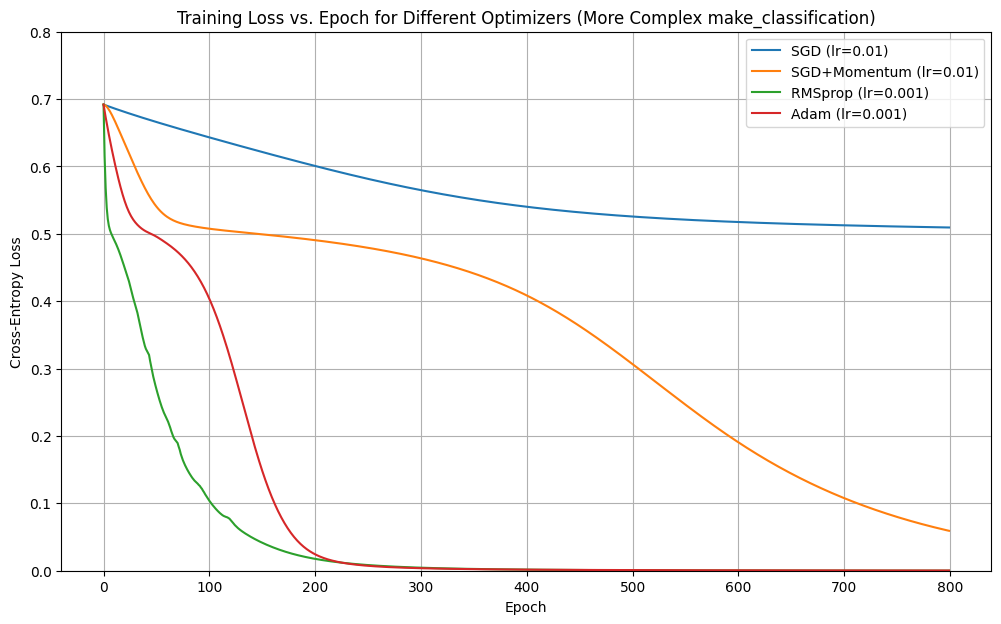

In [ ]:
# 1. Prepare Data
from sklearn.datasets import make_classification
X_complex, y_complex = make_classification(n_samples=1000, n_features=30, n_informative=25, n_redundant=5,
                                           n_clusters_per_class=4, flip_y=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_complex, y_complex, test_size=0.3, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Convert to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_t = torch.tensor(X_train_s, dtype=torch.float32).to(device)
y_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_test_s, dtype=torch.float32).to(device)
y_val = torch.tensor(y_test, dtype=torch.long).to(device)

# 2. Define the Model
class SmallNet(nn.Module):
    def __init__(self, input_dim=30):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)

# 3. Training Loop Function
def train_model(optimizer_name, optimizer_class, lr):
    torch.manual_seed(42) # Reset seeds for fair comparison
    model = SmallNet().to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    epochs = 800
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_t)
        loss = criterion(outputs, y_t)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        preds = model(X_val).argmax(dim=1)
        acc = (preds == y_val).float().mean().item()
    print(f'{optimizer_name}: Final val acc {acc:.4f}')
    return losses

# 4. Run Experiments
# We use learning rates that are generally considered "good starting points" for each
loss_sgd = train_model('SGD (lr=0.01)', lambda p, lr: optim.SGD(p, lr=lr), lr=0.01)
loss_momentum = train_model('SGD+Momentum (lr=0.01)', lambda p, lr: optim.SGD(p, lr=lr, momentum=0.9), lr=0.01)
loss_rmsprop = train_model('RMSprop (lr=0.001)', lambda p, lr: optim.RMSprop(p, lr=lr), lr=0.001)
loss_adam = train_model('Adam (lr=0.001)', lambda p, lr: optim.Adam(p, lr=lr), lr=0.001)

# 5. Plot Loss Curves
plt.figure(figsize=(12, 7))
plt.plot(loss_sgd, label='SGD (lr=0.01)')
plt.plot(loss_momentum, label='SGD+Momentum (lr=0.01)')
plt.plot(loss_rmsprop, label='RMSprop (lr=0.001)')
plt.plot(loss_adam, label='Adam (lr=0.001)')
plt.title('Training Loss vs. Epoch for Different Optimizers (More Complex make_classification)')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 0.8)
plt.show()

**Practical Comparison Takeaways:**

The plot shows the training loss curves for the different optimizers on a synthetic dataset.

-   **SGD (Blue):** As expected, plain SGD is very slow to converge compared to the others. It is still decreasing but is far behind.
-   **SGD+Momentum (Orange):** Shows a clear improvement over plain SGD, converging much faster and reaching a lower loss within the given epochs.
-   **RMSprop (Green):** Converges relatively quickly, performing significantly better than plain SGD and competitive with Adam initially. You can see that RMSprop's loss drops quite rapidly in the early epochs.
-   **Adam (Red):** Initially, Adam's convergence might appear slightly slower than RMSprop in the very first few epochs. However, as training progresses, Adam's adaptive learning rate and momentum combination allow it to find a more efficient path through the complex loss landscape. It overtakes RMSprop and achieves the lowest training loss and highest validation accuracy among all the optimizers within the allotted time.

**When Adam is generally better:**

Adam is often preferred and is the **default choice** for most deep learning tasks because:
1.  **Robustness:** It's less sensitive to the initial learning rate choice compared to SGD or Momentum.
2.  **Speed:** It typically converges faster than SGD and Momentum, especially on complex problems.
3.  **Adaptivity:** Its per-parameter adaptive learning rates allow it to handle sparse gradients and different scales of gradients across parameters efficiently.

While RMSprop is a great optimizer, Adam's inclusion of the momentum term (first moment estimate) in addition to the adaptive learning rate (second moment estimate) often gives it a slight edge in overall convergence speed and stability on a wide variety of tasks, particularly as the complexity of the model and data increases and when training for a sufficient number of epochs.

## 9) Summary and Recommendations

| Optimizer | Key Idea | Pros | Cons |
| :--- | :--- | :--- | :--- |
| **SGD** | Basic gradient update. | Low memory. | Very slow, sensitive to LR, gets stuck. |
| **Momentum** | Adds velocity term. | Faster than SGD, helps escape local minima. | Still sensitive to LR. |
| **Adagrad** | Per-parameter LR based on *sum* of sq. grads. | Good for sparse data. | Learning rate dies and stops training. |
| **RMSprop** | Per-parameter LR based on *moving avg* of sq. grads. | Fixes Adagrad, fast adaptation. | |
| **Adam** | Combines Momentum (1st moment) and RMSprop (2nd moment). | **The default.** Fast, robust, adaptive. | Can sometimes converge to sharp minima. |
| **AdamW** | Adam with *decoupled weight decay* (L2 reg). | **The new default.** Often generalizes better than Adam. | Not in all libraries (but is in PyTorch). |